In [1]:
print('Running')

Running


In [2]:
# Cell 1: Install dependencies
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
! pip install scikit-learn matplotlib seaborn pillow tqdm torchsummary


Looking in indexes: https://download.pytorch.org/whl/cu126
  Using cached https://download.pytorch.org/whl/cu126/torch-2.6.0%2Bcu126-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu126/torchvision-0.21.0%2Bcu126-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.6.0%2Bcu126-cp312-cp312-win_amd64.whl.metadata (6.8 kB)
  Using cached https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached https://download.pytorch.org/whl/typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached https://download.pytorch.org/whl/networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached https://download.pytorch.org/whl/Jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached https://download.pytorch.org/whl/fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached https://download.pytorch.org/whl/setuptools-70.2.0-py3-none-any.

In [1]:
# Cell 2: Import all required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score

# Device configuration
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
! nvidia-smi

Thu Apr  3 10:53:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8              8W /   95W |    4293MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Cell 3: Data transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

visualization_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [3]:
# Cell 4: Load datasets and create data loaders
train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
valid_dataset = datasets.ImageFolder(root='valid', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Classes: {train_dataset.classes}")

Training dataset size: 70295
Validation dataset size: 17572
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',

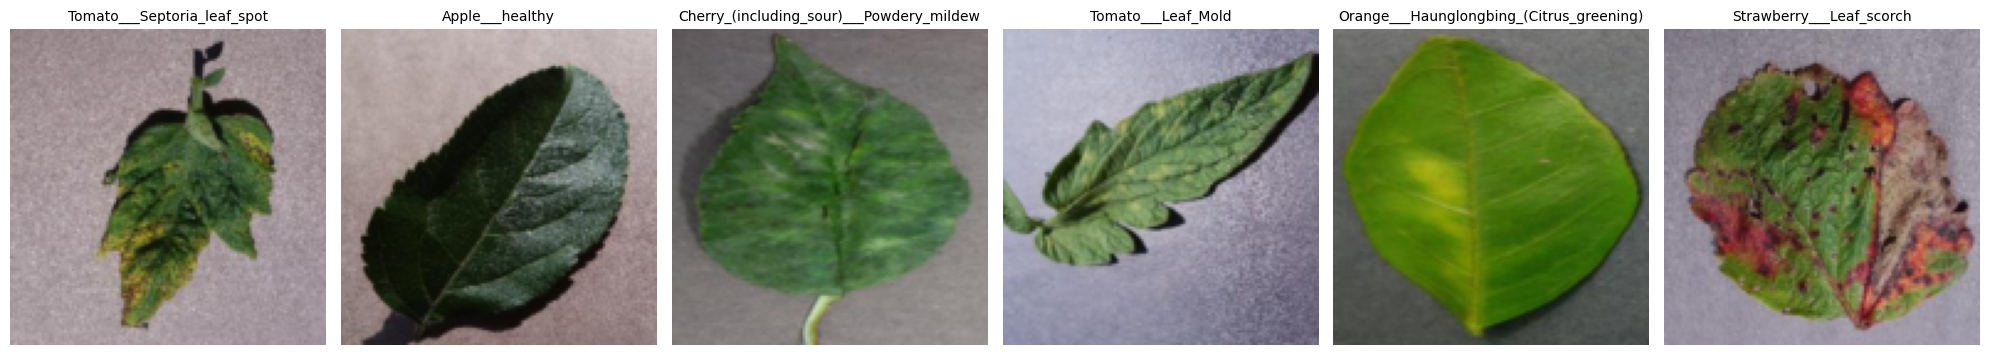

In [4]:
# Cell 5: Image visualization function
def show_images(data_loader, class_names, num_images=6):
    images, labels = next(iter(data_loader))
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    
    for i in range(num_images):
        img = images[i].permute(1, 2, 0)
        img = img.numpy()
        img = img.clip(0, 1)
        label = class_names[labels[i].item()]
        axes[i].imshow(img)
        axes[i].set_title(label, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Create visualization dataset
visualization_dataset = datasets.ImageFolder(root='train', transform=visualization_transform)
visualization_loader = DataLoader(visualization_dataset, batch_size=6, shuffle=True)

# Display sample images
show_images(visualization_loader, train_dataset.classes)

In [5]:
# Cell 6: Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)  # Corrected for 128x128 input
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 128x128 -> 64x64
        x = self.pool(F.relu(self.conv2(x)))  # 64x64 -> 32x32
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes).to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=38, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [6]:
# Cell 7: Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Store class names with model
model.class_names = train_dataset.classes

In [10]:
# Cell 8: Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    epoch_progress = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    
    for batch_idx, (images, labels) in enumerate(epoch_progress):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_progress.set_postfix({
            'Batch': f'{batch_idx+1}/{len(train_loader)}',
            'Batch Loss': f'{loss.item():.4f}',
            'Avg Loss': f'{running_loss/(batch_idx+1):.4f}'
        })
    
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/3], Avg Loss: 1.1434


Epoch [2/3], Avg Loss: 0.5387


Epoch [3/3], Avg Loss: 0.3808


In [21]:
# New Save Cell (Run this only once)
def save_model_properly(model, class_names, path='complete_model.pth'):
    # Save only what we need for prediction
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names,
        'input_size': (3, 128, 128)
    }, path)
    print(f"Model saved to {path} - Note: You'll need to redefine the architecture when loading")

save_model_properly(model, train_dataset.classes)

Model saved to complete_model.pth - Note: You'll need to redefine the architecture when loading


In [12]:
# Cell 10: Validation and metrics
model.eval()
all_preds = []
all_labels = []
all_outputs = []

with torch.no_grad():
    for images, labels in tqdm(valid_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_outputs.append(outputs.cpu())

# Basic metrics
print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

100%|██████████| 1099/1099 [05:08<00:00,  3.56it/s]


Accuracy: 0.9265
Precision: 0.9288
Recall: 0.9265
F1 Score: 0.9265

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.90      0.88      0.89       504
                                 Apple___Black_rot       0.92      0.98      0.95       497
                          Apple___Cedar_apple_rust       0.89      0.95      0.92       440
                                   Apple___healthy       0.91      0.91      0.91       502
                               Blueberry___healthy       0.93      0.93      0.93       454
          Cherry_(including_sour)___Powdery_mildew       0.98      0.97      0.98       421
                 Cherry_(including_sour)___healthy       0.97      0.97      0.97       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.92      0.84      0.88       410
                       Corn_(maize)___Common_rust_       1.00      0.97      0.9

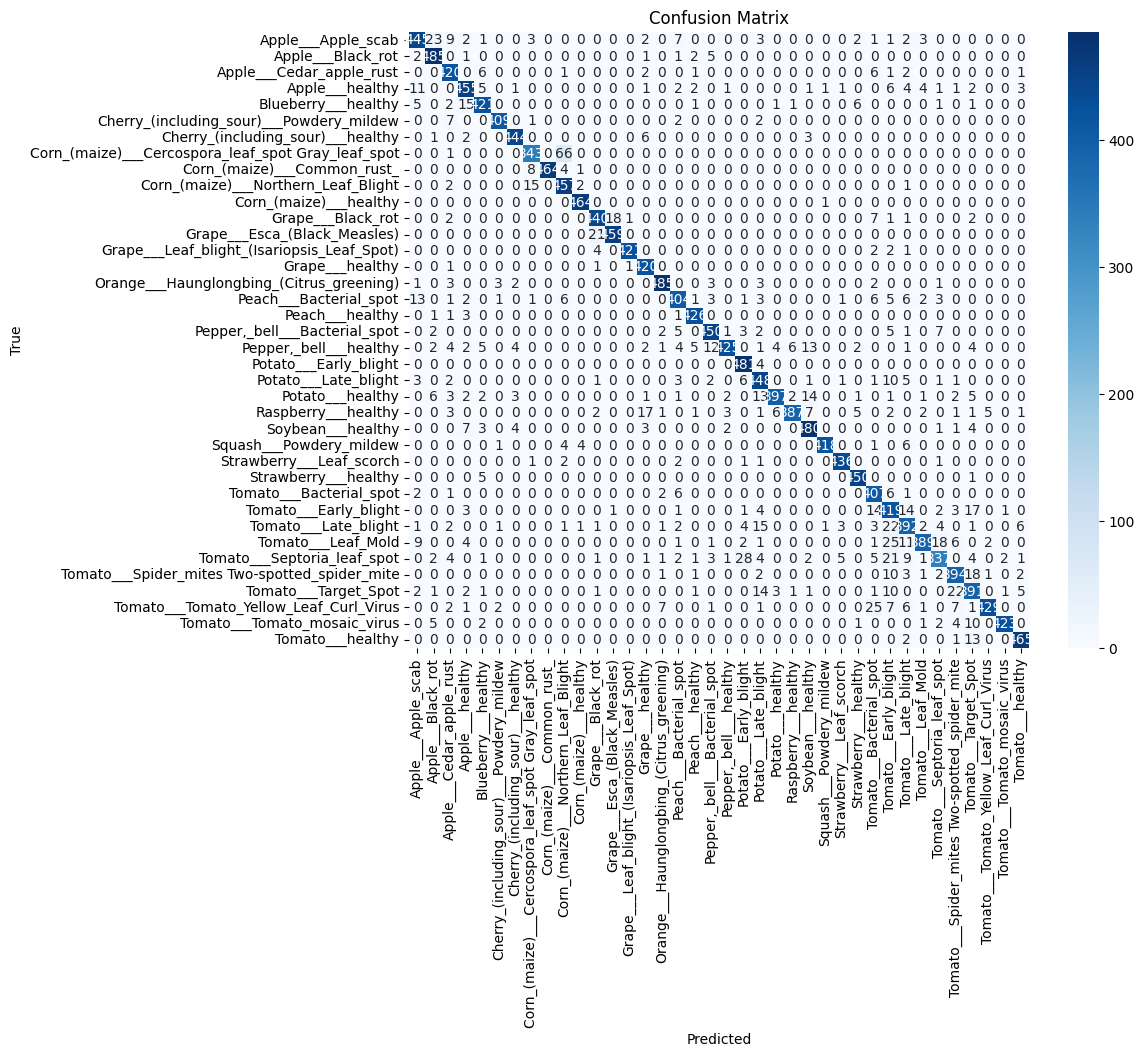

In [13]:
# Cell 11: Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

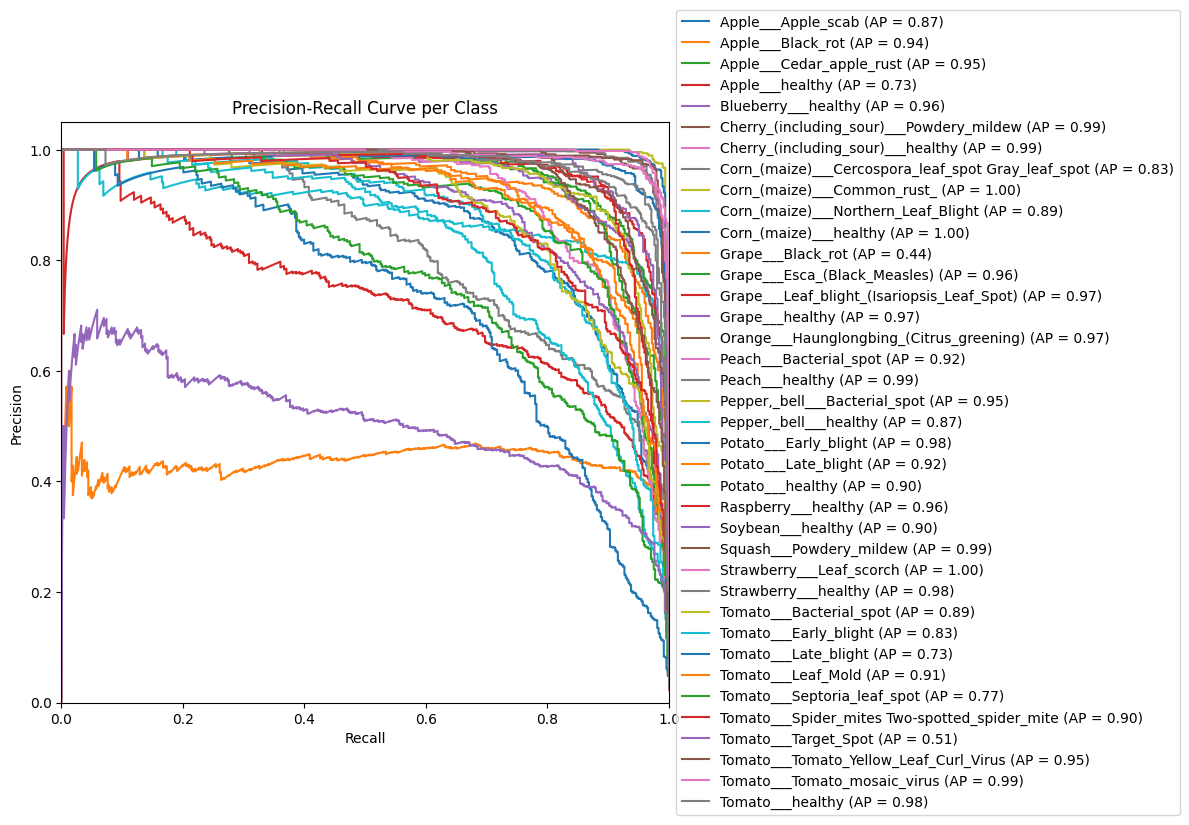

In [14]:
# Cell 12: Precision-Recall Curve
y_true_bin = label_binarize(all_labels, classes=np.arange(num_classes))
y_pred = torch.cat(all_outputs).numpy()

precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred[:, i])

plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], 
             label=f'{train_dataset.classes[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve per Class')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()



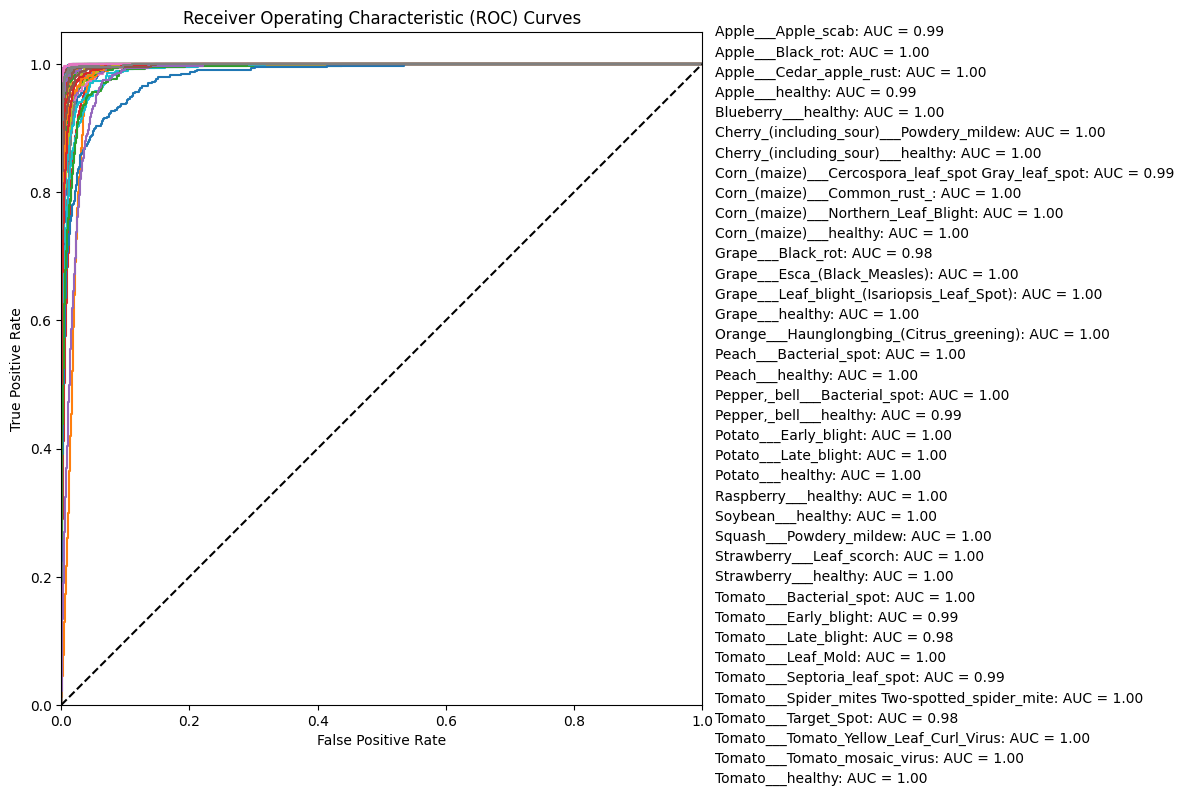

In [15]:
# Cell 13: ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')

for i in range(num_classes):
    plt.text(1.02, 1.0 - (i * 0.03),
             f'{train_dataset.classes[i]}: AUC = {roc_auc[i]:.2f}',
             ha='left', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

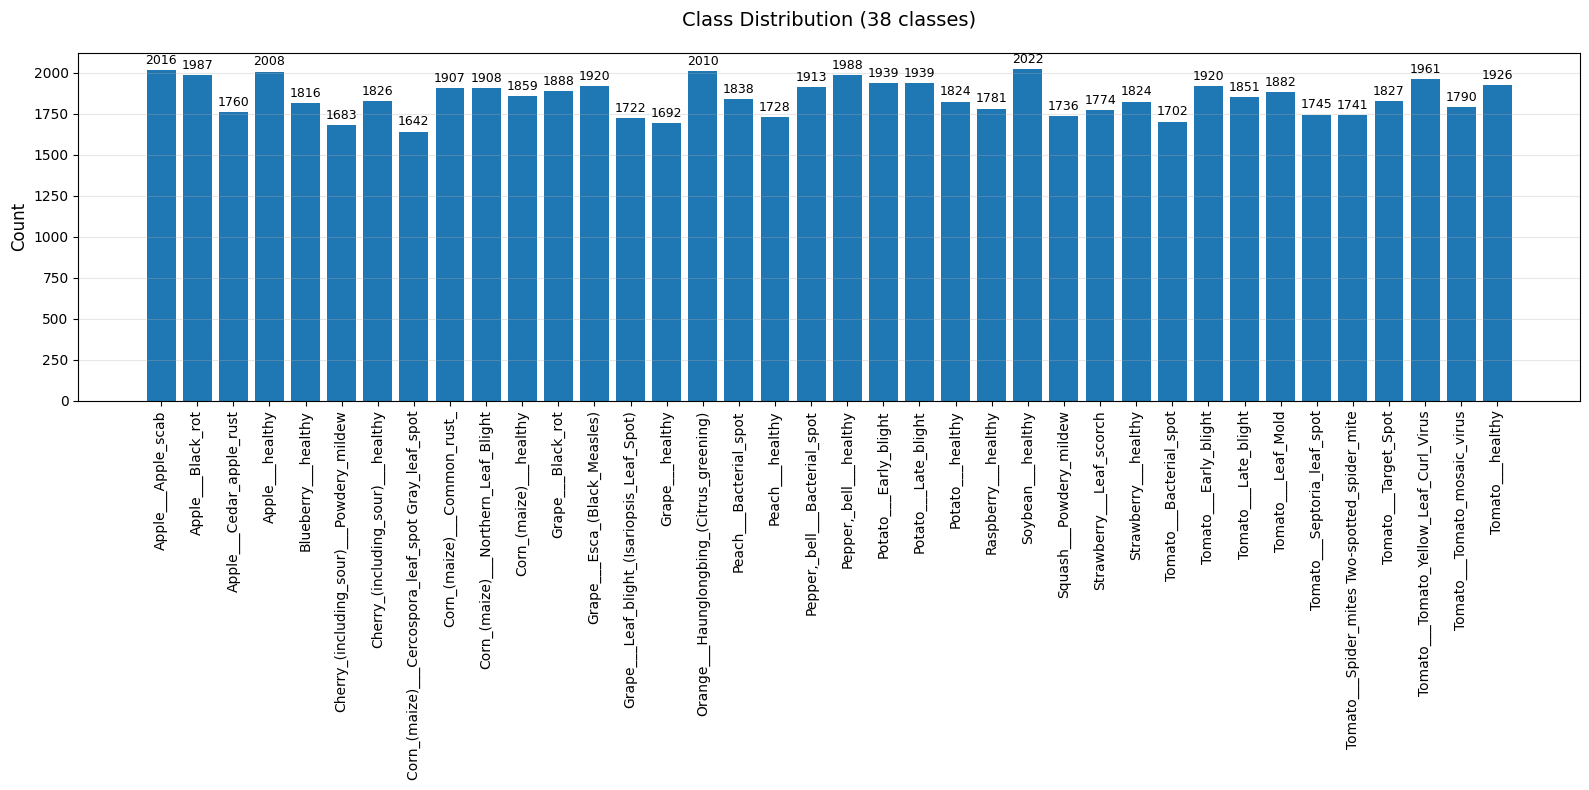

In [16]:
# Cell 14: Class Distribution
class_counts = np.bincount(train_dataset.targets)
plt.figure(figsize=(16, 8))
plt.subplots_adjust(bottom=0.3)

bars = plt.bar(range(num_classes), class_counts, width=0.8)

for idx, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + max(class_counts)*0.01,
             str(int(height)),
             ha='center',
             va='bottom',
             fontsize=9)

plt.xticks(range(num_classes), train_dataset.classes, rotation=90, fontsize=10)
plt.ylabel('Count', fontsize=12)
plt.title(f'Class Distribution ({num_classes} classes)', fontsize=14, pad=20)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Model loaded successfully!


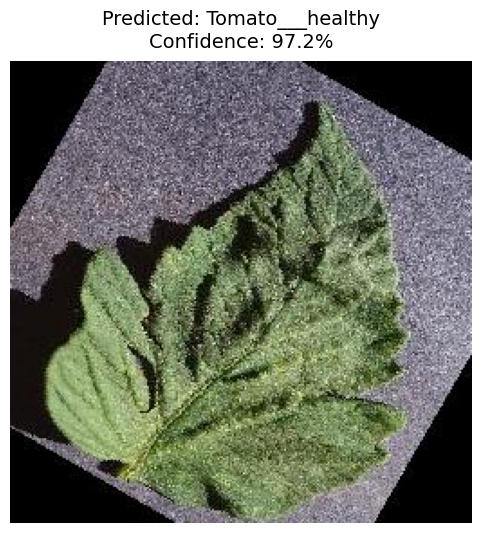

Final Prediction: Tomato___healthy


In [2]:
# Cell 15 (Complete Fixed Version): Load model and predict
# 1. First redefine the model architecture EXACTLY as during training
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 2. Define the prediction function
def predict_image(model, image_path, transform):
    try:
        image = Image.open(image_path)
        input_image = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_image)
            _, predicted = torch.max(output, 1)
            predicted_class = model.class_names[predicted.item()]
            probabilities = F.softmax(output, dim=1)[0] * 100
        
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_class}\nConfidence: {probabilities[predicted.item()]:.1f}%", 
                 fontsize=14, pad=10)
        plt.axis('off')
        plt.show()
        return predicted_class
    except Exception as e:
        print(f"Prediction error: {e}")
        return None

# 3. Load the model
def load_model_for_prediction(path):
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    model = SimpleCNN(len(checkpoint['class_names'])).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_names = checkpoint['class_names']
    model.eval()
    return model

# 4. Execute prediction
try:
    loaded_model = load_model_for_prediction('complete_model.pth')
    print("Model loaded successfully!")
    
    # Make sure this matches your validation transform
    val_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    image_path = 'test/TomatoHealthy3.jpg'  # CHANGE TO YOUR IMAGE PATH
    predicted_class = predict_image(loaded_model, image_path, val_transform)
    if predicted_class:
        print(f"Final Prediction: {predicted_class}")
except Exception as e:
    print(f"Loading error: {e}")